In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [7]:
# Import countries shapefile
fp = os.path.join('data','ne_50m_admin_0_countries','ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()  # Simplify column names
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [2]:
# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)
communities

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)
3,Vec-Liepāja,85260,LV,454432,POINT (21.01667 56.53333)
4,Tukums,18348,LV,454768,POINT (23.15528 56.96694)
...,...,...,...,...,...
1419,Centralniy,214625,RU,8504960,POINT (30.36072 59.93111)
1420,Svetlanovskiy,85508,RU,8504964,POINT (30.33051 60.00276)
1421,Sampsonievskiy,39318,RU,8504965,POINT (30.34295 59.98499)
1422,Vostochnoe Degunino,95000,RU,8505053,POINT (37.55758 55.88010)


In [4]:
# Import country names from URL
URL = 'https://raw.githubusercontent.com/MEDS-eds-220/MEDS-eds-220-course/refs/heads/main/book/chapters/lesson-12-merge-data/country_names.csv'
country_names = pd.read_csv(URL)
country_names

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden
5,BY,Belarus
6,FI,Finland
7,NO,Norway
8,DK,Denmark
9,FO,Faroe Islands


The CRS of the 'communities' geodataframe is EPSG:4326 because all GeoJSON files are given in this CRS


In [8]:
countries.crs == communities.crs

True

Since the CRS match, we can plot them together

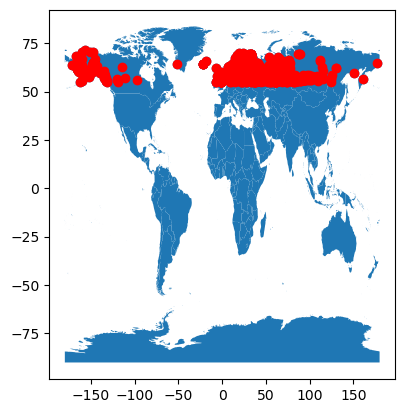

In [9]:
fig, ax = plt.subplots()
countries.plot(ax=ax)
communities.plot(ax=ax)
communities.plot(ax=ax, color='red')
plt.show()

## Arctic communities by country

In [17]:
# Number of arctic communities by country
n_comms = communities.groupby('country').size().reset_index(name='n_communities')
n_comms

IndentationError: unexpected indent (757590535.py, line 3)

## 'if-else' statements

Our goal is to merge 'c_comms' per country with the 'counties' geometries: to merge them, we want them to have a least one column in common. 


In [18]:
set(countries.columns)

{'admin', 'geometry', 'type'}

In [20]:
set(countries.columns.intersection(n_comms.columns))

Index([], dtype='object')

In [22]:
common_columns = set(countries.columns).intersection(n_comms.columns)

# Check if there are any common columns
if len(common_columns) != 0:
    print(f"Common columns: {common_columns}")
else:
    print("No columns in common.")

No columns in common.


## Check-in

Wrap up the previous code into a function called 'check_common_columns' that prints a message depending on whether two general dataframes haave column names in common

In [35]:
# Check if there are any common column names

# New variables: df2, df2
def check_column_names(df1, df2):
    """
    Prints a message depending whether df1 and df2 have columns in common.
    """

    common_columns = set(df1.columns).intersection(df2.columns)
if len(common_columns) != 0:
    print(f"Common column names: {common_columns}")
else:
    print("No column names in common.")
#return: common_columns

No column names in common.


## Merging data frames

We want to: 

1. use the 'country_names' data frame to add the country names to the 'c_comms' data.
2. merge the resulting data frame with 'country_names'

To merge dataframes we can use 'pandas.merge()' function:
```python
output_df = pd.merge(left_df,                   #df "on the left side"
                    right_df,                   #df "on the right side"
                    how = type_of_join,         # type of join, default = inner join
                    on = column_to_join)        # which column to join on, must be in both dataframes

In [37]:
n_comms = pd.merge(n_comms,
                    country_names,
                    how = 'left',
                    on = 'country')

In [40]:
check_column_names(n_comms, countries)

## Check-in 
create a nrw variable called 'arcti_countries' which is the result of an inner join between our countires and c_comms dataframes.


In [51]:
arctic_countries = pd.merge(countries,
                            n_comms,
                            how = 'inner',
                            on = 'admin')

In [42]:
arctic_countries

,country,n_communities,admin,type,geometry
0,BY,8,Belarus,Sovereign country,"POLYGON ((31.76338 52.10107, 31.57373 52.10811..."
1,CA,7,Canada,Sovereign country,"MULTIPOLYGON (((-132.65552 54.12749, -132.5640..."
2,DK,72,Denmark,Country,"MULTIPOLYGON (((12.56875 55.78506, 12.57119 55..."
3,EE,14,Estonia,Sovereign country,"MULTIPOLYGON (((27.35195 57.52812, 27.32656 57..."
4,FI,98,Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65..."
5,FO,1,Faroe Islands,Dependency,"MULTIPOLYGON (((-6.62319 61.80596, -6.64277 61..."
6,GB,96,United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51..."
7,GL,1,Greenland,Country,"MULTIPOLYGON (((-29.95288 83.56484, -28.99199 ..."
8,IS,5,Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224..."
9,LT,26,Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55..."


Checking the resulting we notice we lost the Aland Islands. Let's double check it.

In [52]:
# Update Index
arctic_countries = arctic_countries.set_index('admin')
arctic_countries

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48
Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55...",LT,26
Latvia,Sovereign country,"POLYGON ((26.59355 55.66753, 26.54287 55.67241...",LV,25
Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224...",IS,5
Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65...",FI,98


In [46]:
# Check Aland isalnd is nowhere in data frame
'Aland Islands' in arctic_countries.values

False

The Aland Islands is an autonomous region of Finland and there is one Arctic community registered in this region.
We will directly add one to Finland to account for this.  

In [47]:
arctic_countries.at['Finland', 'n_communities'] += 1

In [48]:
arctic_countries.at['Finland', 'n_communities']

99

## Chloropleth map

To make the map we just need to specify the 'column' parameter in 'plot()' and make it equal to the column with the values we want to plot in each country:

<Axes: >

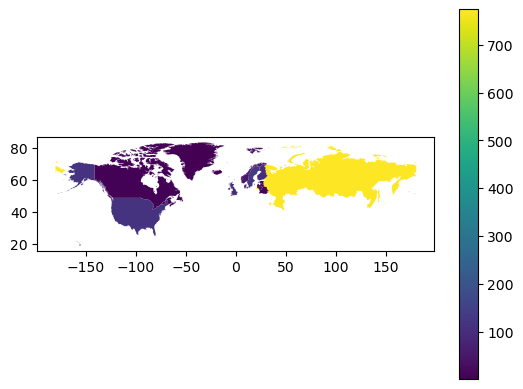

In [53]:
arctic_countries.plot(column='n_communities',
                      legend=True)

## Reprojecting

'to_crs()' method for 'geopandas.GeoDataFrame'

```python
updated_geodf.to_crs(new_crs)
```

here `new_crs` is the CRS we want to convert to, this is an object of type CRS or aa string representing the CRS

<Axes: >

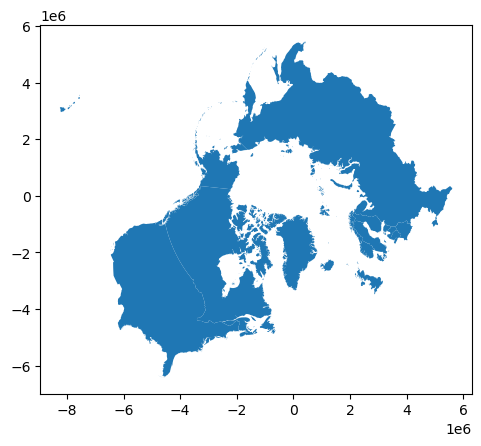

In [55]:
# Reproject to CRS optimized for Arctic region
arctic_countries = arctic_countries.to_crs('epsg:3413')
arctic_countries.plot()

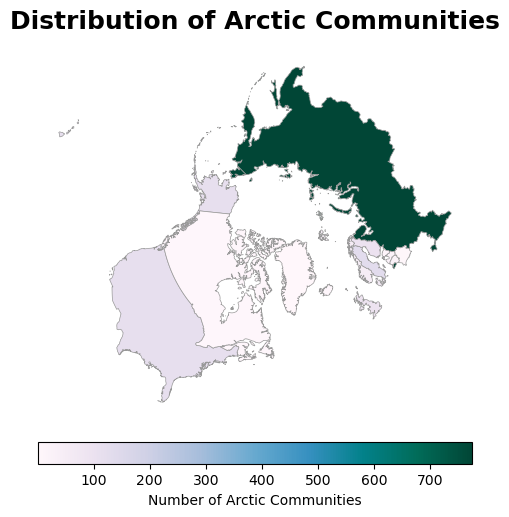

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
arctic_countries.plot(
    ax=ax,
    column='n_communities',
    cmap='PuBuGn',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "Number of Arctic Communities",
        "orientation": "horizontal",
        "pad": 0.05
    }
)

# Add title and subtitle for better context
ax.set_title('Distribution of Arctic Communities', fontsize=18, weight='bold', pad=15)

plt.show()

# 